In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode

In [14]:
sns.set_theme(style='whitegrid')

In [15]:
# Чтение данных из облака
def download_link(public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [16]:
df = pd.read_csv(download_link('https://disk.yandex.ru/d/ELWMdYDmCd2Qog'))

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Есть ли в данных пропущенные значения?

In [17]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [18]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [19]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [20]:
df.timestamp = pd.to_datetime(df.timestamp)
df.weather_code = pd.to_numeric(df.weather_code, downcast='integer')
df.is_holiday = pd.to_numeric(df.is_holiday, downcast='integer')
df.is_weekend = pd.to_numeric(df.is_weekend, downcast='integer')
df.season = pd.to_numeric(df.season, downcast='integer')


In [21]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code              int8
is_holiday                int8
is_weekend                int8
season                    int8
dtype: object

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

In [22]:
df['day'] = df.timestamp.dt.strftime('%Y-%m-%d')

Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:

data.resample(rule='D').column_name.sum() #способ 1
data.resample(rule='D').agg({'column_name':'sum'}) #способ 2, эквивалентный предыдущему

Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?



In [23]:
df.drop('day', axis=1, inplace=True)

In [24]:
df = df.sort_values('timestamp').set_index('timestamp')

In [25]:
df_cnt_by_day = df.resample(rule='D').agg({'cnt': 'sum'}).reset_index()

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

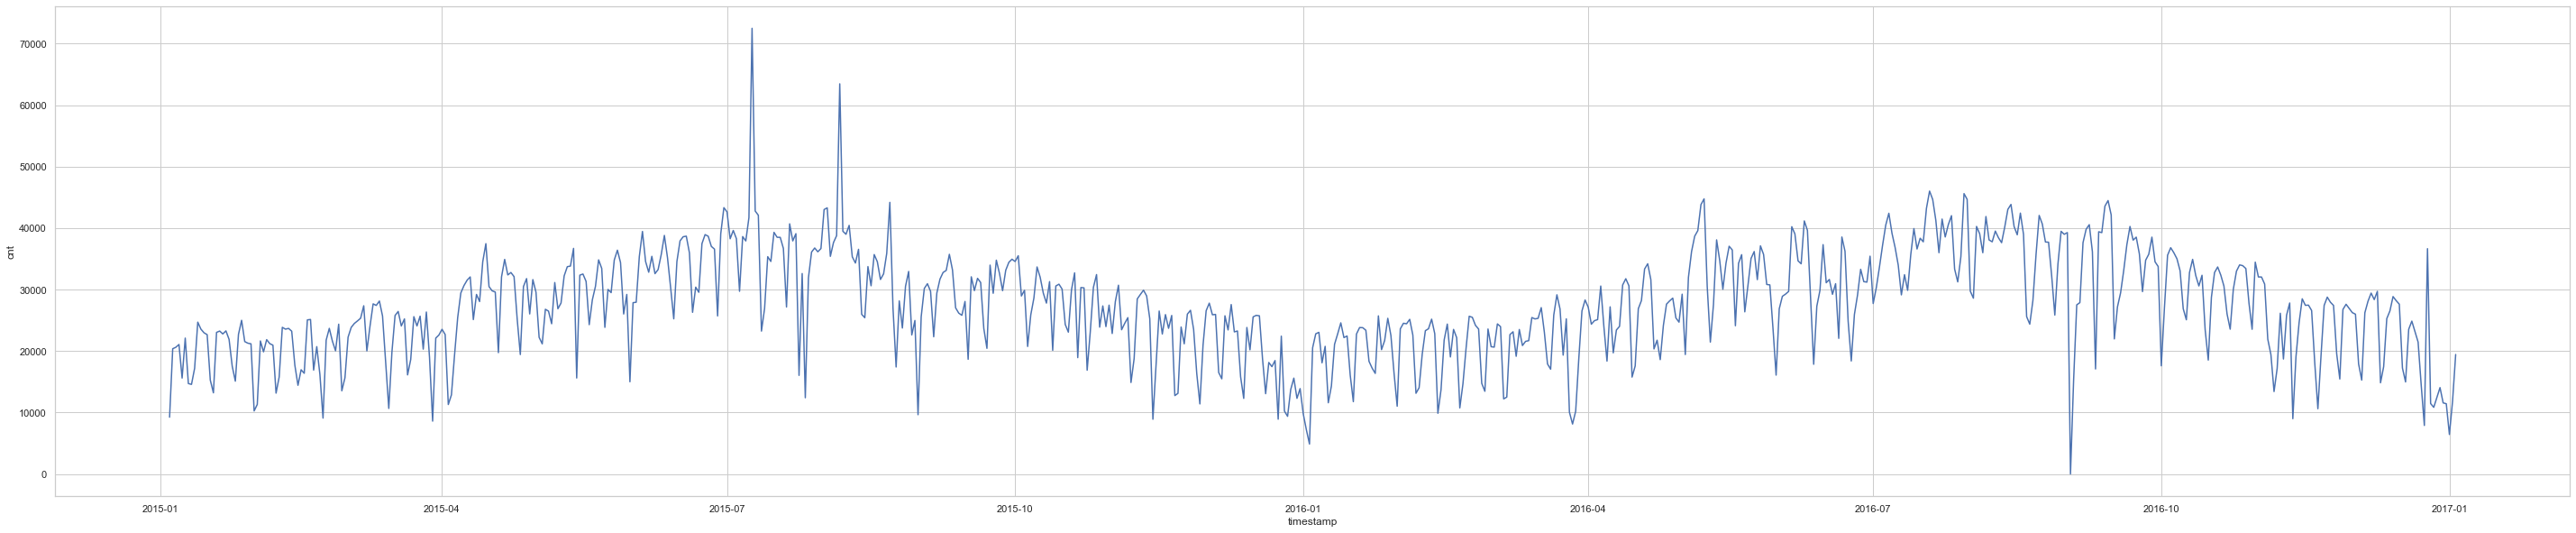

In [26]:
plt.figure(figsize=(50, 10))
sns.lineplot(data=df_cnt_by_day, x='timestamp', y='cnt')

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [27]:
df_cnt_by_day['cnt_rolling_mean'] = df_cnt_by_day.cnt.rolling(3).mean()

In [28]:
df_cnt_by_day.query("timestamp == '2015-07-09'")

,timestamp,cnt,cnt_rolling_mean
186,2015-07-09,72504,50705.0


In [29]:
df_cnt_by_day['diff'] = df_cnt_by_day['cnt'] - df_cnt_by_day['cnt_rolling_mean']

In [30]:
std = np.std(df_cnt_by_day['diff'])

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

upper_bound – верхняя граница; к средним прибавляем 2.576∗std
lower_bound – нижняя граница; вычитаем 2.576∗std
Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

In [31]:
df_cnt_by_day['upper_bound'] = df_cnt_by_day['cnt_rolling_mean'] + 2.576 * std
df_cnt_by_day['lower_bound'] = df_cnt_by_day['cnt_rolling_mean'] - 2.576 * std

In [32]:
df_cnt_by_day.tail(1)

,timestamp,cnt,cnt_rolling_mean,diff,upper_bound,lower_bound
730,2017-01-03,19436,12560.0,6876.0,24302.919188,817.080812


In [33]:
round(24302.919188, 2)

24302.92

In [34]:
df_cnt_by_day

,timestamp,cnt,cnt_rolling_mean,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,1933.666667,21632.252521,-1853.585854


И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? Укажите дату в формате 2020-12-31.

In [35]:
df_cnt_by_day.query('cnt > upper_bound')

,timestamp,cnt,cnt_rolling_mean,diff,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


In [36]:
df_reset_index = df.reset_index()

In [37]:
df_reset_index['day'] = df_reset_index.timestamp.dt.strftime('%Y-%m-%d')

In [38]:
df_reset_index.query("day == '2015-07-09'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,day
4453,2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1,0,0,1,2015-07-09
4454,2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1,0,0,1,2015-07-09
4455,2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1,0,0,1,2015-07-09
4456,2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1,0,0,1,2015-07-09
4457,2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1,0,0,1,2015-07-09
4458,2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1,0,0,1,2015-07-09
4459,2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1,0,0,1,2015-07-09
4460,2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1,0,0,1,2015-07-09
4461,2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2,0,0,1,2015-07-09
4462,2015-07-09 09:00:00,4832,15.0,15.0,59.0,16.0,2,0,0,1,2015-07-09


Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

In [39]:
df_cnt_by_day.query('cnt < lower_bound')

,timestamp,cnt,cnt_rolling_mean,diff,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812
